In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn
from tqdm import tqdm
df = pd.read_csv('moviecopy.csv')

2023-08-15 16:08:26.855317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df.isnull().sum()
#0 null so no need to clear null
print(df.duplicated().sum())
#418 duplicated, no we need to clear duplicates
df=df.drop_duplicates() 
print(df.duplicated().sum())
#duplicates are cleared
df.head()

0
0


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
import re
def stringClear(text):
    cleanText = re.sub(r'[!,.""?''()]',' ',text)
    return cleanText

df['text'] = df['text'].apply(stringClear)
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,label
0,i grew up b 1965 watching and loving the th...,0
1,when i put this movie in my dvd player and sa...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWordList = stopwords.words("english")

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stopWordList]).apply(lambda x:" ".join(x))
#unnecessary words are eliminated
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eceokutan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said made laugh cameo ...,0
6,finally watched shocking movie last night dist...,1
7,caught film azn cable sounded like would good ...,0
8,may remake 1987 autumn's tale eleven years dir...,1


In [5]:

def catAsNum(val):
    if val=="positive":
        return 1
    else:
        return 0
#df['label']  =  df['label'].apply(catAsNum)

In [6]:
x = df["text"].values
y = df["label"].values

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(7,)
(2,)
(7,)
(2,)


In [8]:
len(x_train)

7

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
train_encodings = tokenizer(list(x_train), padding = "max_length", truncation=True)
test_encodings = tokenizer(list(x_test), padding = "max_length", truncation=True)

BATCHSIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCHSIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCHSIZE)



/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 665/665 [00:00<00:00, 777kB/s]
Downloading: 100%|██████████| 0.99M/0.99M [00:00<00:00, 1.16MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 872kB/s] 
Downloading: 100%|██████████| 1.29M/1.29M [00:00<00:00, 1.61MB/s]


In [10]:
'''
tokenizer(list(x_train))
tokenizer(x_train)
tokenizer(list(x_train))["input_ids"]
tokenizer(list(x_train),padding = "max_length")
tokenizer(list(x_train),padding = "max_length")
'''


'\ntokenizer(list(x_train))\ntokenizer(x_train)\ntokenizer(list(x_train))["input_ids"]\ntokenizer(list(x_train),padding = "max_length")\ntokenizer(list(x_train),padding = "max_length")\n'

In [11]:
""" 
import tensorflow_datasets as tfds
train_dataframe = tfds.as_dataframe(train_dataset) 
test_dataframe = tfds.as_dataframe(test_dataset) 
"""

' \nimport tensorflow_datasets as tfds\ntrain_dataframe = tfds.as_dataframe(train_dataset) \ntest_dataframe = tfds.as_dataframe(test_dataset) \n'

In [12]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


In [13]:
def sequence_classification_loss(y_true, y_pred):
    # Taking the logits from the last token only (you might adjust this based on your exact use-case)
    y_pred = y_pred[:, -1, :]
    return tf.keras.losses.SparseCategoricalCrossentropy(y_true, y_pred, from_logits=True)

In [15]:
from transformers import TFAutoModelForSequenceClassification
from transformers import TextClassificationPipeline
model = TFAutoModelForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels = 2,
    label2id = label2id,
    id2label = id2label)

#https://www.analyticsvidhya.com/blog/2021/12/all-nlp-tasks-using-transformers-package/
pipeline = TextClassificationPipeline(model=model,
                                      tokenizer=tokenizer,
                                      framework='tf',
                                      device=0)

model.compile(
    loss = sequence_classification_loss,
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), #hyperparameter
    metrics = ["accuracy"] #hyperparameter sayılır
)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.summary()

Model: "tfgpt2_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 score (Dense)               multiple                  1536      
                                                                 
 transformer (TFGPT2MainLay  multiple                  124439808 
 er)                                                             
                                                                 
Total params: 124441344 (474.71 MB)
Trainable params: 124441344 (474.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
EPOCHS = 1 #hyperparameter
history = model.fit(
    x= train_dataset,
    validation_data = test_dataset,
    epochs = EPOCHS
)

TypeError: in user code:

    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/55/m_f_x3bd49n0hfdm6nm4wnnc0000gp/T/ipykernel_33773/1421279567.py", line 4, in sequence_classification_loss  *
        return tf.keras.losses.SparseCategoricalCrossentropy(y_true, y_pred, from_logits=True)

    TypeError: __init__() got multiple values for argument 'from_logits'


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
out = model.predict(test_dataset)
pred = np.argmax(out[0], axis = 1)
pred

1/1 [==============================] - 4s 4s/step


array([1, 1])

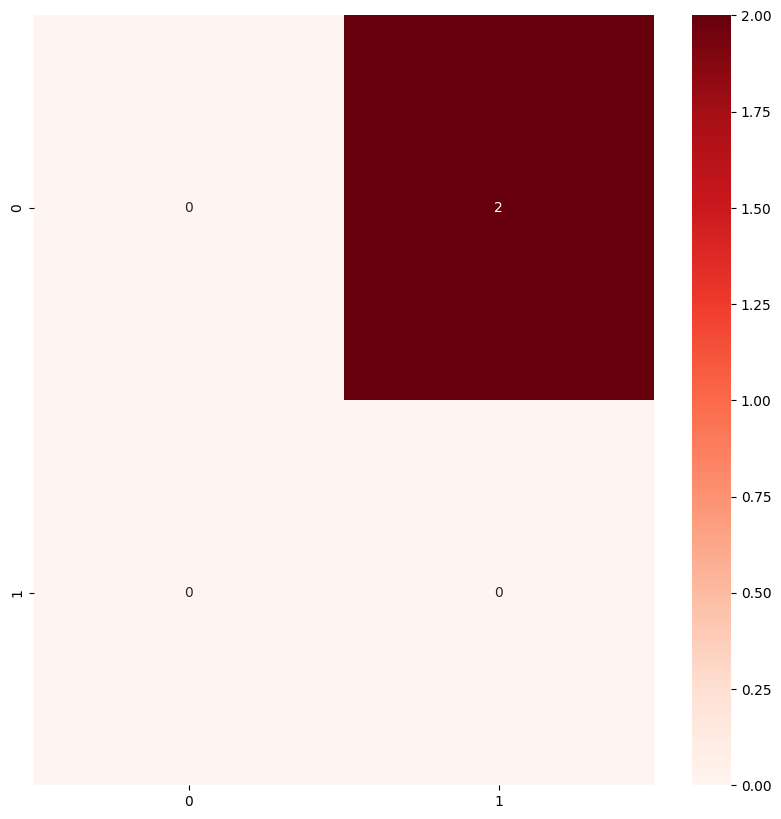

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap='Reds')
plt.show()